# The Insulin Minimal Model

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [ ]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [ ]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/modsim.py')

In [53]:
# import functions from modsim

from modsim import *

The following cells download and read the data.

In [ ]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSim/main/data/glucose_insulin.csv')

In [54]:
data = pd.read_csv('glucose_insulin.csv', index_col='time');

In Chapter 17 I present the glucose minimal model; in Chapter 18 we implemented it using `run_simulation` and `run_solve_ivp`.
In this case study, we'll implement the other half of the Minimal Model, which describes the concentration of insulin.

In the insulin minimal model, the concentration of insulin, $I$, is governed by this differential equation:

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

where $G(t)$ is the concentration of glucose at time $t$, and
$k$, $\gamma$, and $G_T$ are positive-valued parameters:

* $k$ controls the rate of insulin disappearance.

* $G_T$ determines the glucose threshold: when $G(t)$ exceeds this threshold, it causes insulin to appear; when $G(t)$ is below this threshold, it causes insulin to disappear.

* $\gamma$ controls how quickly insulin appears or disappears when the concentration of glucose is elevated or depressed.
 
Notice that this equation depends on time, $t$, since the initial injection.  It has the effect of increasing glucose sensitivity over time.  If you are familiar with control systems, the effect of this term is similar to the integral term in a [PID controller](https://en.wikipedia.org/wiki/PID_controller).

In addition to the three parameters in the equation, we will also consider the initial concentration of insulin, $I_0$, to be a free parameter; that is, we will choose the value of $I_0$, and the other parameters, that best fit the data.

**Exercise:**  Write a version of `make_system` that takes the parameters of the model (`I0`, `k`, `gamma`, and `G_T`) as parameters, along with a `DataFrame` containing the measurements, and returns a `System` object suitable for use with `run_solve_ivp`.

Use it to make a `System` object with the following parameters:

In [55]:
I0 = 360   
k = 0.25
gamma = 0.004
G_T = 80

params = I0, k, gamma, G_T

In [56]:
# Solution goes here
def make_system(params, data):
    I0, k, gamma, G_T = params
    
    init = State(I = I0, X = 0)
    
    t0 = data.index[0]
    t_end = data.index[-1]

    G = interpolate(data.glucose)
        
    return System(init=init, t0=t0, t_end=t_end, k=k, gamma=gamma, G_T=G_T, G=G)

In [57]:
# Solution goes here
system = make_system(params, data)
system

namespace(init=I    360
               X      0
               Name: state, dtype: int64,
          t0=np.int64(0),
          t_end=np.int64(182),
          k=0.25,
          gamma=0.004,
          G_T=80,
          G=<scipy.interpolate._interpolate.interp1d at 0x125293d40>)

**Exercise:** Write a slope function that takes a time stamp, a `State` object, and a `System` object, and returns the derivative of `I` with respect to time.  Test your function with the initial conditions from `system`.

$ \frac{dI}{dt} = -k I(t) + \gamma (G(t) - G_T) t $

In [58]:
# Solution goes here
def slope_func(t, state, system):
    I, X = state
    G = system.G
    k, gamma, G_T = system.k, system.gamma, system.G_T
    dIdt = -k * I + gamma * (G(t) - G_T) * t
    return dIdt

In [59]:
# Solution goes here
slope_func(system.t0, system.init, system)

np.float64(-90.0)

**Exercise:** Run `run_solve_ivp` with your `System` object and slope function, and plot the results, along with the measured insulin levels.  Use the keyword argument `t_eval=data.index` so the results are evaluated as the same time stamps as the data.

In [60]:
# Solution goes here
results, details = run_solve_ivp(system, slope_func, t_eval=data.index)
details.success, details.message

(True, 'The solver successfully reached the end of the integration interval.')

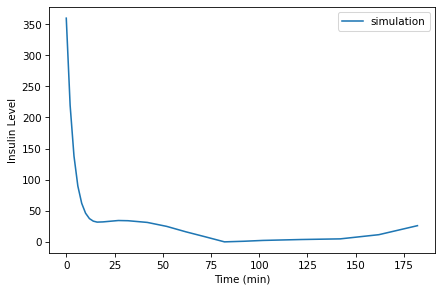

In [61]:
# Solution goes here
results.I.plot(label='simulation')
decorate(xlabel='Time (min)',ylabel='Insulin Level')

In [ ]:
# Solution goes here

**Exercise:**  Write an error function that takes a sequence of parameters as an argument, along with the `DataFrame` containing the measurements.  It should make a `System` object with the given parameters, call `run_solve_ivp`, and compute the difference between the results of the simulation and the measured values.  Test your error function by calling it with the parameters from the previous exercise.

Hint: As we did with the glucose model, you might want to drop the first 2-3 elements from the sequence of errors.

In [62]:
# Solution goes here
def error_func(params, data):
    """Computes an array of errors to be minimized.
    
    params: sequence of parameters
    data: DataFrame of values to be matched
    
    returns: array of errors
    """
    print(params)
    
    # make a System with the given parameters
    system = make_system(params, data)
    
    # solve the ODE
    results, details = run_solve_ivp(system, slope_func, 
                                     t_eval=data.index)
    
    # compute the difference between the model
    # results and actual data
    errors = results.I - data.insulin
    return errors.iloc[3:]

In [63]:
# Solution goes here
error_func(params, data)

(360, 0.25, 0.004, 80)


6       4.553116
8      10.709171
10     -3.172829
12     -7.897145
14     -7.985017
16     -3.553263
19      1.776561
22      2.618612
27      7.007712
32      3.686015
42      8.941163
52      9.586846
62      0.796609
72     -3.204869
82    -10.374173
92     -7.410135
102    -9.055942
122    -3.586778
142    -3.563592
162     3.186066
182    18.705483
dtype: float64

**Exercise:** Use `leastsq` to find the parameters that best fit the data.  Make a `System` object with those parameters, run it, and plot the results along with the measurements.

In [64]:
# Solution goes here
best_params, fit_details = leastsq(error_func, params, data)

[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.6e+02 2.5e-01 4.0e-03 8.0e+01]
[3.60000005e+02 2.50000000e-01 4.00000000e-03 8.00000000e+01]
[3.60000000e+02 2.50000004e-01 4.00000000e-03 8.00000000e+01]
[3.60000000e+02 2.50000000e-01 4.00000006e-03 8.00000000e+01]
[3.60000000e+02 2.50000000e-01 4.00000000e-03 8.00000012e+01]
[3.54335448e+02 2.53013238e-01 3.60571294e-03 7.98118985e+01]
[3.54335454e+02 2.53013238e-01 3.60571294e-03 7.98118985e+01]
[3.54335448e+02 2.53013242e-01 3.60571294e-03 7.98118985e+01]
[3.54335448e+02 2.53013238e-01 3.60571299e-03 7.98118985e+01]
[3.54335448e+02 2.53013238e-01 3.60571294e-03 7.98118997e+01]
[3.54240796e+02 2.53013945e-01 3.61090278e-03 8.05524363e+01]
[3.54240796e+02 2.53013945e-01 3.61090278e-03 8.05524363e+01]
[3.54246469e+02 2.53013925e-01 3.61063400e-03 8.03474382e+01]
[3.54268023e+02 2.53013750e-01 3.60950984e-03 7.99261133e+01]
[3.54301512e+02 2.53013328e-01 3.60760354e-03 7.98241357e+01]
[3.54318856e+02 2.53013098e-01

In [65]:
# Solution goes here
best_params, fit_details

(array([3.54332794e+02, 2.53012727e-01, 3.60582239e-03, 7.98119145e+01]),
 namespace(cov_x=array([[ 1.79698820e+00, -1.69837900e-05,  5.33762222e-05,
                          1.55095586e-01],
                        [-1.69837900e-05,  2.36135640e-10, -4.62330442e-10,
                         -2.22843815e-06],
                        [ 5.33762222e-05, -4.62330442e-10,  1.60894254e-09,
                          4.17759790e-06],
                        [ 1.55095586e-01, -2.22843815e-06,  4.17759790e-06,
                          6.87734229e-02]]),
           mesg='The relative error between two consecutive iterates is at most 0.000000',
           ier=2,
           fvec=array([  0.92778288,   7.45935373,  -6.19807384, -10.82192822,
                       -10.92323518,  -6.59240459,  -1.46645   ,  -0.80726134,
                         3.45901816,   0.21423267,   5.67599748,   6.98425116,
                        -0.82204101,  -3.92186269, -10.12482534,  -7.19417843,
                       

In [66]:
# Solution goes here
system2 = make_system(best_params, data)
results2, details2 = run_solve_ivp(system2, slope_func, t_eval=results.index)

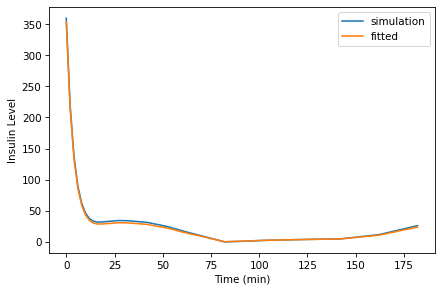

In [67]:
# Solution goes here
results.I.plot(label='simulation')
results2.I.plot(label='fitted')
decorate(xlabel='Time (min)',ylabel='Insulin Level')

In [ ]:
# Solution goes here

**Exercise:** Using the best parameters, estimate the sensitivity to glucose of the first and second phase pancreatic responsivity:

$ \phi_1 = \frac{I_{max} - I_b}{k (G_0 - G_b)} $

$ \phi_2 = \gamma \times 10^4 $

For $G_0$, use the best estimate from the glucose model, 272 mg/dL.  For $G_b$ and $I_b$, use the initial measurements from the data.
For $I_{max}$ is the maximum measurement of insulin concentration.

In [68]:
# Solution goes here
G0 = 272
Gb = data.glucose[0]
Ib = data.insulin[0]
Imax = max(data.insulin)
G0, Gb, Ib, Imax

(272, np.int64(92), np.int64(11), 130)

In [69]:
# params = I0, k, gamma, G_T
best_params, params

(array([3.54332794e+02, 2.53012727e-01, 3.60582239e-03, 7.98119145e+01]),
 (360, 0.25, 0.004, 80))

In [70]:
# Solution goes here
phi_1 = (Imax - Ib) / ( best_params[1] * (G0 - Gb))
phi_2 = best_params[2] * 10000
phi_1, phi_2

(np.float64(2.612955950391983), np.float64(36.05822391307365))

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

In [ ]:
# Solution goes here

According to [Pacini and Bergman](https://www.researchgate.net/publication/13707725_Insulin_sensitivity_and_glucose_effectiveness_Minimal_model_analysis_of_regular_and_insulin-modified_FSIGT), here are the normal ranges for these quantities.

In [72]:
phi_1_interval = 2, 4
phi_1_interval

(2, 4)

In [73]:
phi_2_interval = 20, 35
phi_2_interval

(20, 35)

Do your estimates fall in these ranges?

In [76]:
def in_range(phi, phi_range):
    return phi > phi_range[0] and phi < phi_range[1]

In [77]:
in_range(phi_1, phi_1_interval), in_range(phi_2, phi_2_interval)

(np.True_, np.False_)